In [4]:

import sys, os
sys.path.append('C:\\Users\\bartm\\Documents\\These\\phyloreplica\\src')
from PhyloDataset import *
from PhyloTrees import *
from vae import *
import torch
torch.autograd.set_detect_anomaly(True)

datapath1 = "../data/PF00072/PF00072_rp15_has_PF00196.faa"
datapath2 = "../data/PF00072/PF00072_rp15_has_PF00486.faa"
datapath3 = "../data/PF00072/PF00072_rp15_has_PF00512.faa"
datapath4 = "data/PF00072/PF00072_rp15_has_PF00158.faa"
datapath5 = "data/PF00072/PF00072_rp15_has_PF00990.faa"
datapath6 = "data/PF00072/PF00072_rp15_has_PF01339.faa"
datapath7 = "data/PF00072/PF00072_rp15_has_PF04397.faa"
datapath8 = "data/PF00072/PF00072_rp15_has_PF12833.faa"

lossfn = vae_loss

dataset1 = MSA(datapath1)
dataset2 = MSA(datapath2)
dataset3 = MSA(datapath3)
lt = len(dataset1) + len(dataset2) + len(dataset1)
l1 = int(32*len(dataset1)/lt) 
l2 = int(32*len(dataset2)/lt) 
l3 = 32 - l1 -l2

vae1 = VAE(21, 5, dataset1.len_protein * dataset1.q, [512, 256, 128])
optimizer1 = optim.Adam(vae1.parameters(),weight_decay=0.01)
Node1 = PhyloNode(vae1,
          optimizer1, 
          lossfn,
          parent=None, 
          children=[], 
          dataset = dataset1, 
          tuplesize=2, 
          batch_size=l1, 
          gammaManager = gammaManager_Independant(),
          Name = "196"
    )


vae2 = VAE(21, 5, dataset2.len_protein * dataset2.q, [512, 256, 128])
optimizer2 = optim.Adam(vae2.parameters(),weight_decay=0.01)
Node2 = PhyloNode(vae2,
          optimizer2, 
          lossfn,
          parent=None, 
          children=[], 
          dataset = dataset2, 
          tuplesize=2, 
          batch_size=l2, 
          gammaManager = gammaManager_Independant(),
          Name="486"
    )


vae3 = VAE(21, 5, dataset3.len_protein * dataset3.q, [512, 256, 128])
optimizer3 = optim.Adam(vae3.parameters(),weight_decay=0.01)
Node3 = PhyloNode(vae3,
          optimizer3, 
          lossfn,
          parent=None, 
          children=[], 
          dataset = dataset3, 
          tuplesize=2, 
          batch_size=l3, 
          gammaManager = gammaManager_Independant(),
          Name="512"
    )

vaeR =  VAE(21, 5, dataset3.len_protein * dataset3.q, [512, 256, 128])
optimizerR = optim.Adam(vaeR.parameters(),weight_decay=0.01)
NodeR = PhyloNode(vaeR,
          optimizer3, 
          lossfn,
          parent=None, 
          children=[], 
          dataset = dataset3, 
          tuplesize=2, 
          batch_size=32, 
          gammaManager = gammaManager_Independant(),
          Name="Root"
    )


In [6]:
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer1, factor=0.5, patience=10, verbose=True
)

In [14]:
trainL = int(0.8 * len(dataset1))
testL = int(0.1 * len(dataset1))
valL = len(dataset1) - trainL -testL
batch_size = 64
train_set, test_set,  val_set = torch.utils.data.random_split(dataset1, [trainL, testL, valL])
train_iterator = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_iterator = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_iterator = DataLoader(val_set, batch_size=batch_size, shuffle=True)


In [18]:
for epoch in range(100):
    print(epoch)
    vae1.train()
    train_loss_list = []
    for batch_idx, batch in enumerate(train_iterator):
        x,w = batch[0], batch[1]
        #targ = targ.unsqueeze(1)
        loss = -vae1.compute_weighted_elbo(x, w)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        train_loss_list.append(loss.item())
    
#         l2_reg = torch.tensor(0.)
#         for param in Dcla.parameters():
#             l2_reg += torch.norm(param)
#         loss += l2_lambda * l2_reg

    print(" acc train" ,np.mean(train_loss_list))
#     scheduler.step(np.mean(train_loss_list))
    test_loss_list = []
    with  torch.no_grad():
        for batch_idx, batch in enumerate(test_iterator):
            x,w = batch[0], batch[1]
            loss = -vae1.compute_weighted_elbo(x, w)
            test_loss_list.append(loss.item())
    print(" acc val" ,np.mean(test_loss_list))


0
 acc train 204.53567902907514
 acc val 205.4270546166579
1
 acc train 203.50727385637046
 acc val 204.14234303127202
2
 acc train 202.26023094538542
 acc val 202.00684154112255
3
 acc train 200.65438359120253
 acc val 200.69545820363027
4
 acc train 198.97053537566242
 acc val 199.8662372129823
5
 acc train 197.6810588367946
 acc val 198.3893510942112
6
 acc train 196.7912746605711
 acc val 197.97041772420317
7
 acc train 197.12000389956597
 acc val 198.45399415136487
8
 acc train 195.82646905048833
 acc val 196.7679419281017
9
 acc train 194.65443221147336
 acc val 196.73703722525394
10
 acc train 193.73209173865354
 acc val 196.8974296206834
11
 acc train 194.18732172662854
 acc val 196.98742779726157
12
 acc train 193.26308507306092
 acc val 195.3205991268063
13
 acc train 192.52886123866023
 acc val 195.76202529664664
14
 acc train 192.39569608933564
 acc val 194.31402398995502
15
 acc train 191.67377383367028
 acc val 194.04485889730023
16
 acc train 190.9551520296777
 acc val 1

In [21]:
a = torch.tensor(1)
b = torch.tensor(2)
torch.min((a,2))

TypeError: min(): argument 'input' (position 1) must be Tensor, not tuple

# kmeans Splitter

In [10]:
dataset1.sequences.shape
len(dataset1)

8219

In [29]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5, random_state=0).fit(dataset1.sequences)
kmeans.labels_
    #array([1, 1, 1, 0, 0, 0], dtype=int32)
# kmeans.predict([[0, 0], [12, 3]])
    #array([1, 0], dtype=int32)
kmeans.cluster_centers_
#     array([[10.,  2.],
#            [ 1.,  2.]])

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.74103586],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.56358582],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.84168656],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.64452214],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [30]:
sum(kmeans.labels_==4)

332

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dataset1.sequences)

PCA(n_components=2)

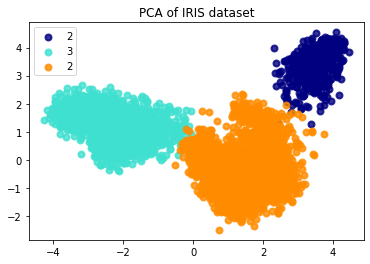

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
X_r = pca.transform(dataset1.sequences)
colors = ["navy", "turquoise", "darkorange", "red", "blue"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], kmeans.labels_):
    plt.scatter(
        X_r[kmeans.labels_ == i, 0], X_r[kmeans.labels_ == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.figure()

plt.show()

In [34]:
sub = torch.utils.data.Subset(dataset1, kmeans.labels_==4)

In [36]:
sub[:][0].shape

torch.Size([332, 2352])